In [1]:
import pandas as pd
import numpy as np
from datetime import date
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import os
import json
import matplotlib.pyplot as plt


# Modelos
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import xgboost as xgb

<center><img src="ml_lfcl.png"></center>


---
# 1. Data collection, Data Cleaning & Feature Engineering

### Método de **Feature Engeneering** e **Limpeza de Dados**

In [2]:
def feature_engeneering(df):
    df_eng = df.copy()

    # --- LIMPEZA INICIAL ---
    df_eng = df_eng.drop_duplicates()
    df_eng['hp'] = df['engine'].str.extract(r'(\d+\.?\d*)HP', expand=False).astype(float)
    df_eng['liters'] = df['engine'].str.extract(r'(\d+\.?\d*)L\s', expand=False).astype(float)

    # --- Idade e Uso ---
    var_ano_atual = date.today().year
    df_eng['car_age'] = var_ano_atual - df_eng['model_year']
    df_eng['car_age'] = df_eng['car_age'].replace(0, 1)

    # --- Cilindrada ---
    df_eng['cylinders'] = df['engine'].str.extract(r'(\d+)\s+Cylinder', expand=False)
    df_eng['cylinders'] = df_eng['cylinders'].fillna(df['engine'].str.extract(r'V(\d+)', expand=False))
    df_eng['cylinders'] = df_eng['cylinders'].astype(float)

    # --- Tecnologias de Motor ---
    df_eng['is_turbo'] = df['engine'].str.contains(r'(?i)turbo', na=False).astype(int)
    df_eng['turbo_type'] = df['engine'].str.extract(r'(Twin Turbo|Turbo)', expand=False)
    df_eng['valve_train'] = df['engine'].str.extract(r'(DOHC|OHV|SOHC)', expand=False) 
    df_eng['fuel_injection'] = df['engine'].str.extract(r'(PDI|GDI|MPFI)', expand=False)

    # --- Miles per year
    df_eng['miles_p_year'] = df_eng['milage'] / df_eng['car_age']

    # --- FUEL TYPE ---
    def clean_fuel(val):
        s = str(val).lower()
        if 'hybrid' in s:
            return 'Hybrid'
        elif 'not supported' in s:
            return 'EV'
        else:
            return val
    df_eng['fuel_type'] = df_eng['fuel_type'].apply(clean_fuel)

    # --- TRANSMISSION TYPE ---
    def clean_transmission(val):
        s = str(val).lower()
        if 'automatic' in s or 'a/t' in s or 'cvt' in s:
            return 'Automatico'
        elif 'manual' in s or 'm/t' in s:
            return 'Manual'
        else:
            return 'Outro'
    df_eng['transmission_type'] = df_eng['transmission'].apply(clean_transmission)
    
    # --- Tratamento de Nulos ---
    df_eng['clean_title'] = df_eng['clean_title'].replace('Unknown', 'No') #Vazio passsa a ser "No"
    
    cols_texto = df_eng.select_dtypes(include=['object']).columns
    df_eng[cols_texto] = df_eng[cols_texto].replace('-', 'Unknown').fillna('Unknown')

    # 1. Eficiência do motor
    # Evitar divisão por zero somando um valor ínfimo
    df_eng['hp_per_liter'] = df_eng['hp'] / (df_eng['liters'] + 0.001)

    # 2. Rácio de Potência por Cilindro
    df_eng['hp_per_cylinder'] = df_eng['hp'] / (df_eng['cylinders'] + 0.001)

    # 3. Quilometragem (Milage)
    # A milage tem uma distribuição muito "cauda longa". O Log ajuda o modelo a ver melhor as diferenças.
    df_eng['milage'] = np.log1p(df_eng['milage'])

    return df_eng

In [3]:
# Recolha os Dados
df_treino = pd.read_csv('dados/train.csv', index_col='id')
df_teste = pd.read_csv('dados/test.csv', index_col='id')

print("✓ Dados lidos com Sucesso!")

✓ Dados lidos com Sucesso!


In [4]:
# Aplicar feature engineering e Limpeza de dados
df_treino_eng = feature_engeneering(df_treino)
df_teste_eng = feature_engeneering(df_teste)

print("✓ Feature Engineering Aplicado com Sucesso!")

✓ Feature Engineering Aplicado com Sucesso!


In [5]:
df_treino_eng.head(5)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,...,car_age,cylinders,is_turbo,turbo_type,valve_train,fuel_injection,miles_p_year,transmission_type,hp_per_liter,hp_per_cylinder
id,,,,,,,,,,,,,,,,,,,,,
0,MINI,Cooper S Base,2007,12.269052,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,...,19,4.0,0,Unknown,Unknown,Unknown,11210.526316,Automatico,107.432854,42.989253
1,Lincoln,LS V8,2002,11.872354,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,...,24,8.0,0,Unknown,Unknown,Unknown,5968.750000,Automatico,64.598821,31.496063
2,Chevrolet,Silverado 2500 LT,2002,11.825778,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,...,24,8.0,0,Unknown,Unknown,Unknown,5697.125000,Automatico,60.365969,39.995001
3,Genesis,G90 5.0 Ultimate,2017,9.878221,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,...,9,8.0,0,Unknown,Unknown,Unknown,2166.666667,Outro,83.983203,52.493438
4,Mercedes-Benz,Metris Base,2021,8.907748,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,...,5,4.0,0,Unknown,Unknown,Unknown,1477.600000,Automatico,103.948026,51.987003


In [6]:
df_teste_eng.head(5)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,...,car_age,cylinders,is_turbo,turbo_type,valve_train,fuel_injection,miles_p_year,transmission_type,hp_per_liter,hp_per_cylinder
id,,,,,,,,,,,,,,,,,,,,,
188533,Land,Rover LR2 Base,2015,11.492733,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,...,11,4.0,0,Unknown,Unknown,Unknown,8909.090909,Automatico,119.940030,59.985004
188534,Land,Rover Defender SE,2020,9.120744,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,...,6,6.0,0,Unknown,Unknown,Unknown,1523.666667,Automatico,131.622792,65.822363
188535,Ford,Expedition Limited,2022,10.244307,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,...,4,6.0,1,Twin Turbo,DOHC,PDI,7030.250000,Automatico,NaN,NaN
188536,Audi,A6 2.0T Sport,2016,11.022866,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,...,10,NaN,0,Unknown,Unknown,Unknown,6125.800000,Automatico,NaN,NaN
188537,Audi,A6 2.0T Premium Plus,2018,10.985310,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,...,8,4.0,0,Unknown,Unknown,Unknown,7375.000000,Automatico,125.937031,62.984254


In [7]:
# Separar target
y = np.log1p(df_treino_eng['price'])
X = df_treino_eng
X_test = df_teste_eng.copy()

# Tipos de Features Relevantes para Previsao
features_numericas = ['hp', 'liters', 'car_age', 'cylinders', 'miles_p_year','milage', 'model_year', 'is_turbo']

# Criar dataset numérico
X_num = X[features_numericas].fillna(0)
X_test_num = X_test[features_numericas].fillna(0)

In [8]:
# Encondificar features categoricas | Tornar valores de texto em numéricos
features_categoricas = ['brand', 'model', 'fuel_type', 'transmission_type', 
                           'clean_title', 'turbo_type', 'valve_train', 'fuel_injection','accident']

print("--- Valores Únicos por Coluna (Antes de Enconding) ---")
for col in features_categoricas:
    unicos = df_treino_eng[col].unique()
    print(f"\nColuna: {col} ({len(unicos)} valores)")
    print(unicos)

--- Valores Únicos por Coluna (Antes de Enconding) ---

Coluna: brand (57 valores)
['MINI' 'Lincoln' 'Chevrolet' 'Genesis' 'Mercedes-Benz' 'Audi' 'Ford'
 'BMW' 'Tesla' 'Cadillac' 'Land' 'GMC' 'Toyota' 'Hyundai' 'Volvo'
 'Volkswagen' 'Buick' 'Rivian' 'RAM' 'Hummer' 'Alfa' 'INFINITI' 'Jeep'
 'Porsche' 'McLaren' 'Honda' 'Lexus' 'Dodge' 'Nissan' 'Jaguar' 'Acura'
 'Kia' 'Mitsubishi' 'Rolls-Royce' 'Maserati' 'Pontiac' 'Saturn' 'Bentley'
 'Mazda' 'Subaru' 'Ferrari' 'Aston' 'Lamborghini' 'Chrysler' 'Lucid'
 'Lotus' 'Scion' 'smart' 'Karma' 'Plymouth' 'Suzuki' 'FIAT' 'Saab'
 'Bugatti' 'Mercury' 'Polestar' 'Maybach']

Coluna: model (1897 valores)
['Cooper S Base' 'LS V8' 'Silverado 2500 LT' ... 'e-Golf SE'
 'Integra w/A-Spec Tech Package' 'IONIQ Plug-In Hybrid SEL']

Coluna: fuel_type (7 valores)
['Gasoline' 'E85 Flex Fuel' 'Unknown' 'Hybrid' 'Diesel' '–' 'EV']

Coluna: transmission_type (3 valores)
['Automatico' 'Outro' 'Manual']

Coluna: clean_title (2 valores)
['Yes' 'Unknown']

Coluna: turbo_

In [9]:
# Preparar features Categoricas
X_cat = X[features_categoricas].copy().astype(str)
X_test_cat = X_test[features_categoricas].copy().astype(str)

X_cat = X_cat.replace('–', 'Unknown')
X_test_cat = X_test_cat.replace('–', 'Unknown')

# Encoding via Mapeamento (Pandas)
for col in features_categoricas:
    # Criar o dicionário baseado no treino: {valor: indice}
    # Ordenar alfabeticamente garante que o encoding seja consistente
    unique_values = sorted(X_cat[col].unique())
    mapping = {val: i for i, val in enumerate(unique_values)}
    
    # Aplicar no Treino
    X_cat[col] = X_cat[col].map(mapping)
    
    # Aplicar no Teste
    # .map() deixa NaN se o valor não existir no mapping. 
    # Usamos .fillna(-1) para novas categorias no teste.
    X_test_cat[col] = X_test_cat[col].map(mapping).fillna(-1).astype(int)

print("✓ Encoding Aplicado com Sucesso!")

✓ Encoding Aplicado com Sucesso!


In [10]:
print("--- Valores Únicos por Coluna (Depois de Enconding) ---")
for col in sorted(features_categoricas):
    unicos = pd.Series(X_cat[col].unique()).sort_values().tolist()  # Converte para lista
    print(f"\nColuna: {col} ({len(unicos)} valores)")
    print(unicos)

--- Valores Únicos por Coluna (Depois de Enconding) ---

Coluna: accident (3 valores)
[0, 1, 2]

Coluna: brand (57 valores)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]

Coluna: clean_title (2 valores)
[0, 1]

Coluna: fuel_injection (4 valores)
[0, 1, 2, 3]

Coluna: fuel_type (6 valores)
[0, 1, 2, 3, 4, 5]

Coluna: model (1897 valores)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 11

In [11]:
# Concatenar features | Features a serem utilizadas para generalização
X_final = pd.concat([X_num, X_cat], axis=1)
X_test_final = pd.concat([X_test_num, X_test_cat], axis=1)

In [12]:
X_final

,hp,liters,car_age,cylinders,miles_p_year,milage,model_year,is_turbo,brand,model,fuel_type,transmission_type,clean_title,turbo_type,valve_train,fuel_injection,accident
id,,,,,,,,,,,,,,,,,
0,172.0,1.6,19,4.0,11210.526316,12.269052,2007,0,31,495,3,0,1,2,3,3,1
1,252.0,3.9,24,8.0,5968.750000,11.872354,2002,0,28,930,3,0,1,2,3,3,0
2,320.0,5.3,24,8.0,5697.125000,11.825778,2002,0,9,1575,1,0,1,2,3,3,1
3,420.0,5.0,9,8.0,2166.666667,9.878221,2017,0,16,758,3,2,1,2,3,3,1
4,208.0,2.0,5,4.0,1477.600000,8.907748,2021,0,36,1077,3,0,1,2,3,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188528,420.0,6.2,9,8.0,5444.444444,10.799596,2017,0,8,604,3,2,1,2,3,3,1
188529,385.0,3.0,8,6.0,3575.000000,10.261197,2018,0,36,206,3,0,1,2,3,3,0
188530,469.0,4.0,5,8.0,2730.000000,9.521568,2021,0,36,223,3,0,1,2,3,3,1


In [13]:
X_test_final

,hp,liters,car_age,cylinders,miles_p_year,milage,model_year,is_turbo,brand,model,fuel_type,transmission_type,clean_title,turbo_type,valve_train,fuel_injection,accident
id,,,,,,,,,,,,,,,,,
188533,240.0,2.0,11,4.0,8909.090909,11.492733,2015,0,26,1390,3,0,1,2,3,3,1
188534,395.0,3.0,6,6.0,1523.666667,9.120744,2020,0,26,1377,4,0,1,2,3,3,1
188535,0.0,3.5,4,6.0,7030.250000,10.244307,2022,1,14,636,3,0,0,1,0,2,1
188536,0.0,0.0,10,0.0,6125.800000,11.022866,2016,0,3,182,3,0,0,2,3,3,1
188537,252.0,2.0,8,4.0,7375.000000,10.985310,2018,0,3,181,3,0,1,2,3,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314218,362.0,3.0,12,6.0,6942.916667,11.330396,2014,0,36,760,3,0,1,2,3,3,1
314219,0.0,0.0,7,0.0,4190.857143,10.286605,2019,1,3,1250,3,0,0,0,3,3,1
314220,333.0,3.0,14,6.0,5545.285714,11.259774,2012,0,3,184,3,0,1,2,3,3,1


---
# 2. Model Training & Evaluation

### Método de **Definição dos Modelos** - Dicionário com objetos dos modelos de previsão.

In [14]:
def obter_modelos():
    modelos = {
        #'Linear Regression': LinearRegression(),

        #'KNN': KNeighborsRegressor(),

        #'Decision Tree': DecisionTreeRegressor(random_state=42),

        #'Random Forest': RandomForestRegressor(random_state=42, n_jobs=-1),

        'XGBoost': xgb.XGBRegressor(random_state=42, n_jobs=-1),

        #'SVR Linear': SVR(kernel='linear'),

        'MLP Small': MLPRegressor(random_state=42, early_stopping=True),
    }

    return modelos

### Métodos para **"GridSearchCV"** - Otimização de Hipérparametrso

In [15]:
def obter_params_grid(nome_modelo):
    grids = {
        'Linear Regression': {
            'fit_intercept': [True, False],
            'copy_X': [True, False],
            'n_jobs': [-1],
            'positive': [True, False]
        },
        'KNN': {
            'n_neighbors': [3, 11],             #'n_neighbors': [3, 5, 7, 11],
            'weights': ['uniform', 'distance'],
            'p': [1, 2] # 1=Manhattan, 2=Euclidean
        },
        'Decision Tree': {
            'max_depth': [5, 10, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'criterion': ['squared_error', 'absolute_error']
        },
        'Random Forest': {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        },
        'XGBoost': {
            'n_estimators': [900, 1000, 1100], #            'n_estimators': [100, 500, 1000],
            'learning_rate': [0.01], #            'learning_rate': [0.01, 0.01, 0.1],
            'max_depth': [2, 3, 4],
            'subsample': [0.7, 0.9, 1.0],
            'colsample_bytree': [0.6, 0.7, 0.9]
        },
        'SVR Linear': {
            'C': [0.1, 1, 10, 100],
            'epsilon': [0.01, 0.1, 0.5]
        },
        'MLP Small': {
            'hidden_layer_sizes': [(50,50,50), (100,50), (100,)],
            'activation': ['tanh', 'relu'],
            'alpha': [0.0001, 0.05],
        }
    }
    return grids.get(nome_modelo, {})

A **Otimização de Hiperparâmetros, ou Hyperparameter Tuning em ingles**, é o processo de encontrar as melhores configurações para um modelo de Machine Learning, ajustando-as sistematicamente para otimizar o seu desempenho, precisão e capacidade de generalização. Os hiperparâmetros são definidos externamente antes da aprendizagem começar, servindo como o "manual de instruções" que molda o comportamento do algoritmo.

Para cada modelo, é definida uma grelha de valores para os hiperparâmetros pretendidos e, posteriormente, com a ajuda de Cross Validation (Validação Cruzada), o modelo é testado em diferentes subconjuntos de dados. No caso do GridSearchCV, o sistema executa uma pesquisa exaustiva, realizando todas as combinações possíveis da grelha para identificar qual delas maximiza uma métrica de desempenho específica, neste caso o RMSE (Root Mean Squared Error).

In [16]:
def executar_grid_search(modelo, nome_modelo, X, y, usar_scaled=False):
    print(f"\nA iniciar GridSearch no modelo:'{nome_modelo}' ")

    # 1. Obter o grid de parâmetros
    param_grid = obter_params_grid(nome_modelo)

    if not param_grid:
        print(f"‼ ATENÇÃO - Nenhum grid de hiperparametros definido para {nome_modelo} !!")
        return modelo

    # 2. Configurar o GridSearch
    # cv -> número de folds no Cross Validation ("Mais folds = Mais tempo de execução")
    grid_search = GridSearchCV(
        estimator=modelo,
        param_grid=param_grid,
        cv=3, 
        scoring='neg_root_mean_squared_error',
        verbose=3,
        n_jobs=-1  # Usa todos os processadores
    )

    # 3. Treinar
    grid_search.fit(X, y)

    # 4. Resultados
    print(f"✓ Melhores Parâmetros: {grid_search.best_params_}")
    print(f"  Melhor RMSE (CV): {-grid_search.best_score_:,.2f}")
    return grid_search.best_estimator_

### Método de **Avaliação de Modelo**

In [17]:
def avaliar_modelo(modelo, X_train, y_train, X_val, y_val, nome_modelo):

    
    print(f"\n{'='*60}")
    print(f"A Treinar o modelo: '{nome_modelo}'")
    print(f"{'='*60}")

    # Treinar
    modelo.fit(X_train, y_train)

    # Previsoes
    y_train_pred = modelo.predict(X_train)
    y_val_pred = modelo.predict(X_val)

    # Métricas de treino
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

    # Métricas de validação
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

    # Exibir resultados
    print(f"\n▶ MÉTRICAS DE TREINO:")
    print(f"  RMSE: {train_rmse:,.2f}")

    print(f"\n▶ MÉTRICAS DE VALIDAÇÃO:")
    print(f"  RMSE: {val_rmse:,.2f}")

    return {
        'modelo': nome_modelo,
        'train_rmse': train_rmse,
        'val_rmse': val_rmse,
        'modelo_treinado': modelo
    }

### Método com **Grafico de Dispersao** (Visualizacao de Previsao vs Real)

In [18]:
def grafico_dispersao(nome_modelo, modelo_obj, X_val, y_val, usar_scaled_viz=False, X_val_scaled=None):
    """
    Função para visualizar previsões vs valores reais para um modelo de regressão.
    
    Parâmetros:
    nome_modelo (str): Nome do modelo.
    modelo_obj (modelo): O modelo treinado.
    X_val (array-like): Dados de validação (não escalados).
    y_val (array-like): Rótulos reais de validação.
    usar_scaled_viz (bool): Se True, usa X_val_scaled para previsões, caso contrário usa X_val.
    X_val_scaled (array-like): Dados de validação escalados (necessário se usar_scaled_viz for True).
    """
    
    # Fazer previsões no conjunto de validação
    if usar_scaled_viz:
        y_pred = modelo_obj.predict(X_val_scaled)  # Previsões usando os dados normalizados
    else:
        y_pred = modelo_obj.predict(X_val)  # Previsões usando os dados originais

    # Criar o gráfico
    plt.figure(figsize=(8, 6))

    # Plotar previsões vs real
    plt.scatter(y_val, y_pred, c='b', marker='o', alpha=0.6, s=20)  # Dispersão das previsões
    plt.plot(y_val, y_val, c='r', linestyle='--', linewidth=2)  # Linha de perfeição (y = y_pred)

    # Configurações do gráfico
    plt.xlabel('Valor Real', fontsize=12)
    plt.ylabel('Valor Previsto', fontsize=12)
    plt.title(f'Previsões vs Real - {nome_modelo}', fontsize=14, fontweight='bold')
    plt.legend(['Previsões', 'Perfect Regressor'], loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.3)

    # Mostrar o gráfico
    plt.tight_layout()
    plt.show()

---

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X_final, y, test_size=0.2, random_state=42)

In [20]:
# Normalizar dados (importante para KNN, SVM e MLP) | Permite que todas as features contribuam equilibradamente para o modelo
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Alinhar as colunas do conjunto de teste com as colunas usadas no treino
# (mesma ordem; preencher colunas em falta com 0)
X_test_aligned = X_test_final.reindex(columns=X_train.columns, fill_value=0)

X_test_scaled = scaler.transform(X_test_aligned)

In [21]:
print(f"✓ Dados preparados:")
print(f"  - Treino: {X_train.shape[0]} amostras")
print(f"  - Validação: {X_val.shape[0]} amostras")
print(f"  - Features: {X_train.shape[1]}")

✓ Dados preparados:
  - Treino: 150826 amostras
  - Validação: 37707 amostras
  - Features: 17


### Treino de Modelos

In [22]:
modelos = obter_modelos()

#Treinar os modelos e Avaliar
resultados = []
modelos_treinados = {}

for nome, modelo in modelos.items():
    # Decidir se usar dados normalizados
    usar_scaled = nome in ['KNN', 'SVR Linear', 'MLP Small']

    # Executar Grid Search para tuning
    if usar_scaled:
        modelo = executar_grid_search(modelo, nome, X_train_scaled, y_train)
        res = avaliar_modelo(modelo, X_train_scaled, y_train, X_val_scaled, y_val, nome)
    else:
        modelo = executar_grid_search(modelo, nome, X_train, y_train)
        res = avaliar_modelo(modelo, X_train, y_train, X_val, y_val, nome)

    resultados.append(res)
    modelos_treinados[nome] = {
        'modelo': res['modelo_treinado'],
        'usar_scaled': usar_scaled
    }



A iniciar GridSearch no modelo:'XGBoost' 
Fitting 3 folds for each of 81 candidates, totalling 243 fits
✓ Melhores Parâmetros: {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 1100, 'subsample': 0.7}
  Melhor RMSE (CV): 0.50

A Treinar o modelo: 'XGBoost'

▶ MÉTRICAS DE TREINO:
  RMSE: 0.49

▶ MÉTRICAS DE VALIDAÇÃO:
  RMSE: 0.50

A iniciar GridSearch no modelo:'MLP Small' 
Fitting 3 folds for each of 12 candidates, totalling 36 fits
✓ Melhores Parâmetros: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50)}
  Melhor RMSE (CV): 0.50

A Treinar o modelo: 'MLP Small'

▶ MÉTRICAS DE TREINO:
  RMSE: 0.49

▶ MÉTRICAS DE VALIDAÇÃO:
  RMSE: 0.50


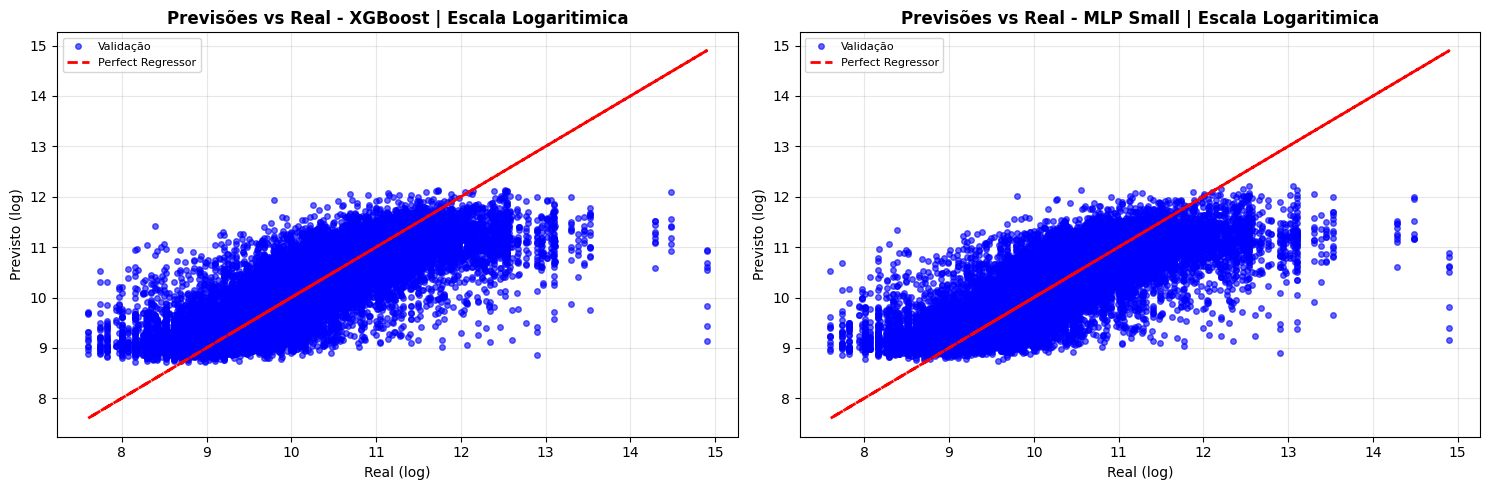

In [23]:
# Criar subplots para todos os modelos
n_modelos = len(modelos_treinados)
n_cols = 2
n_rows = (n_modelos + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Garantir que axes seja sempre um array 1D
if n_rows == 1 and n_cols == 1:
    axes = np.array([axes])
elif n_rows == 1:
    axes = axes  # Já é 1D quando n_rows=1
else:
    axes = axes.flatten()

for idx, (nome_modelo, info_modelo) in enumerate(modelos_treinados.items()):
    modelo_obj = info_modelo['modelo']
    usar_scaled_viz = info_modelo['usar_scaled']
    
    # Fazer previsões no conjunto de validação
    if usar_scaled_viz:
        y_pred = modelo_obj.predict(X_val_scaled)
    else:
        y_pred = modelo_obj.predict(X_val)
    
    ax = axes[idx]
    
    # Plotar previsões vs real
    ax.plot(y_val, y_pred, c='b', marker='o', linestyle='', alpha=0.6, markersize=4)
    ax.plot(y_val, y_val, c='r', linestyle='--', linewidth=2)
    
    ax.set_xlabel('Real (log)', fontsize=10)
    ax.set_ylabel('Previsto (log)', fontsize=10)
    ax.set_title(f'Previsões vs Real - {nome_modelo} | Escala Logaritimica', fontsize=12, fontweight='bold')
    ax.legend(['Validação', 'Perfect Regressor'], loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.3)

# Remover subplots vazios se houver
for idx in range(n_modelos, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

In [24]:
# Comparação final
print(f"\n\n{'='*80}")
print(" ■ COMPARAÇÃO DE MODELOS (ordenados por RMSE de validação)")
print(f"{'='*80}\n")

df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values('val_rmse', ascending=True)

print(df_resultados[['modelo', 'val_rmse']].to_string(index=False))

# Melhor modelo
melhor_resultado = df_resultados.iloc[0]
print(f"\n\n ▶ MELHOR MODELO: {melhor_resultado['modelo']}")
print(f"  RMSE Validação: {melhor_resultado['val_rmse']:,.2f}")



 ■ COMPARAÇÃO DE MODELOS (ordenados por RMSE de validação)

   modelo  val_rmse
  XGBoost  0.498625
MLP Small  0.503516


 ▶ MELHOR MODELO: XGBoost
  RMSE Validação: 0.50


---
# 3. Salvar Submissão & Fazer Log do Modelo

### Método para **guardar log das configurações do modelo**

In [25]:
def salvar_submissao_log(df_sub, modelo_treinado, nome_modelo, metricas):
    pasta = 'submissoes'
    os.makedirs(pasta, exist_ok=True)

    # Descobrir o próximo ID de submissão
    ficheiros = os.listdir(pasta)
    ids_existentes = []
    for f in ficheiros:
        if f.startswith('submission_') and f.endswith('.csv'):
            # Ignorar o ficheiro de log geral se ele começar por 'submission_'
            if f == "Historico_Resultados.csv": continue
            try:
                numero_str = f.replace('submission_', '').replace('.csv', '')
                ids_existentes.append(int(numero_str))
            except ValueError:
                continue
    
    next_id = max(ids_existentes) + 1 if ids_existentes else 1
    
    # Caminhos dos ficheiros
    nome_arquivo_sub = f"submission_{next_id}.csv"
    path_csv_submissao = os.path.join(pasta, nome_arquivo_sub)
    
    # Ficheiro com historico de resultados
    path_log_geral = os.path.join(pasta, "Historico_Resultados.csv")

    # Salvar o ficheiro de submissão individual
    df_sub.to_csv(path_csv_submissao, index=False)

    # Extrair Hiperparâmetros
    try:
        params = modelo_treinado.get_params()
    except:
        params = {"info": "Não foi possível extrair params"}

    # 5. Criar o dicionário com a informação
    dados_log = {
        "id_submissao": next_id,
        "ficheiro_submissao": nome_arquivo_sub,
        "Algoritmo": metricas['modelo'],
        "Treino RMSE": metricas['train_rmse'],
        "Validação RMSE": metricas['val_rmse'],
        "hiperparametros": str(params)
    }
        
    # 6. Salvar/Atualizar o ficheiro CSV ÚNICO
    df_novo_registo = pd.DataFrame([dados_log])

    if os.path.exists(path_log_geral):
        # Se já existe, adiciona a linha nova no fim (append) sem repetir o cabeçalho
        df_novo_registo.to_csv(path_log_geral, mode='a', header=False, index=False)
    else:
        # Se não existe, cria o ficheiro com cabeçalho
        df_novo_registo.to_csv(path_log_geral, index=False)

    print(f"\n✓ Submissão #{next_id} finalizada!")
    print(f" ▱ Ficheiro de submissão: {path_csv_submissao}")
    print(f" ▱ Histórico atualizado em: {path_log_geral}")

In [26]:
melhor_modelo_nome = melhor_resultado['modelo']
melhor_modelo = modelos_treinados[melhor_modelo_nome]['modelo']
usar_scaled = modelos_treinados[melhor_modelo_nome]['usar_scaled']


if usar_scaled:
    X_test_usar = X_test_scaled

else:
    X_test_usar = X_test_aligned

pred_log = melhor_modelo.predict(X_test_usar)
pred_reais = np.expm1(pred_log)

# Submissão
df_submissao = pd.DataFrame({

    'id': df_teste.index,
    'price': pred_reais

})

salvar_submissao_log(df_submissao, melhor_modelo, melhor_modelo_nome, melhor_resultado.to_dict())


✓ Submissão #33 finalizada!
 ▱ Ficheiro de submissão: submissoes\submission_33.csv
 ▱ Histórico atualizado em: submissoes\Historico_Resultados.csv
